## Importing required libraries

In [1]:
import fastai
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from itertools import product
from torch import nn, optim, cuda
from torch.utils import data as torch_data
from fastai import data_block, basic_train, basic_data, train as tr
from fastai import callbacks
from fastai.core import ItemBase

from nn_utils import *

sns.set()
device = 'cuda' if cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
TRAIN_FILE = "all_jets_train_4D_100_percent.pkl"
TEST_FILE = "all_jets_test_4D_100_percent.pkl"
BATCH_SIZE = 64

## Loading the train and test files

In [3]:
train_df = pd.read_pickle(TRAIN_FILE)
test_df = pd.read_pickle(TEST_FILE)
train_df.head()

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


### Normalizing the data using the train mean and train std, even for test data

In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train = (train_df - train_mean) / train_std
test = (test_df - train_mean) / train_std

train.head()

,m,pt,phi,eta
132784,-0.688496,-0.607629,0.868107,0.759040
99666,-0.587358,-0.612672,-1.487534,0.117474
26629,1.051897,1.503479,-1.081401,0.773105
80473,0.788036,1.697702,-0.911068,1.813972
48229,-0.578692,-0.628716,1.619709,-0.830115


## Sample 5000 random samples from the dataset for making a heatmap of correlations

In [5]:
partial_train_df = pd.read_pickle(TRAIN_FILE).sample(5000)
partial_test_df = pd.read_pickle(TEST_FILE).sample(5000)
train_df.head()

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


## Some Visualizations on the Normalized Data

### The distributions of each feature

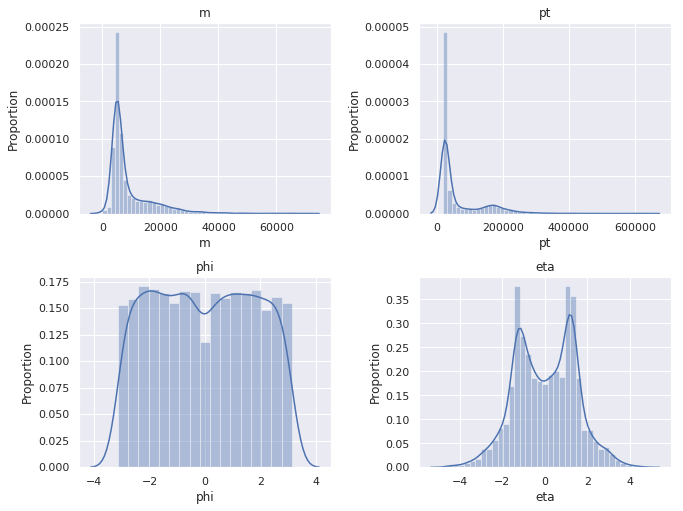

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(4.8 * 2, 3.6 * 2))

for i, axis in enumerate(ax.flatten()):
    _ = sns.distplot(partial_train_df.loc[:, partial_train_df.columns[i]], ax=axis)
    _.set_title(partial_train_df.columns[i])
    _.set_ylabel("Proportion")

_ = plt.tight_layout()

### A Pairwise plot of each feature with every other feature

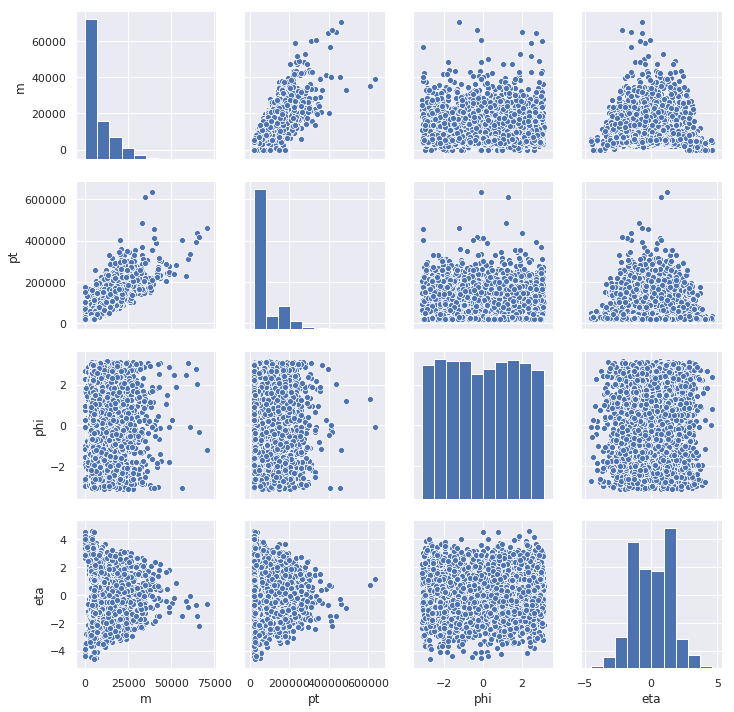

In [7]:
_ = sns.pairplot(data=partial_train_df)

### A heat map of each column against every other

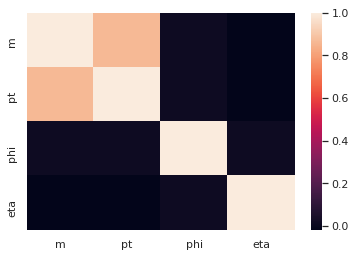

In [8]:
NUM_COLUMNS = len(partial_train_df.columns)
heatmap_mtx = np.zeros((NUM_COLUMNS,) * 2)

for i, col1 in enumerate(partial_train_df.columns):
    for j, col2 in enumerate(partial_train_df.columns):
        x = partial_train_df[[col1]].values.T[0]
        y = partial_train_df[[col2]].values.T[0]
        heatmap_mtx[i, j] = np.corrcoef(x, y)[0, 1]


_ = sns.heatmap(data=heatmap_mtx, xticklabels=partial_train_df.columns, yticklabels=partial_train_df.columns)

#### This heat map shows us a very high correlation between the features 'pt' and 'm', which means the auto encoder might learn a mixed representation.

### Making Torch Dataset and DataLoader instances

In [9]:
train_data = torch_data.TensorDataset(torch.FloatTensor(train.values), torch.FloatTensor(train.values))
test_data = torch_data.TensorDataset(torch.FloatTensor(test.values), torch.FloatTensor(test.values))

train_loader = torch_data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = torch_data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)
NO_BATCHES = len(train_loader)
# making databunch instances to feed to fastai learner
db = basic_data.DataBunch(train_loader, test_loader)

In [10]:
# Root Mean Squared Loss to use for the model
class RMSELoss(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss,self).__init__(*args, **kwargs)

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

rmse_loss = RMSELoss()

### Finding the optimal learning rate for the model

In [11]:
model = AE_3D_200()
learn = basic_train.Learner(
    data=db,
    model=model,
    loss_func=rmse_loss,
    wd=1e-6, callback_fns=callbacks.ActivationStats,
    bn_wd=False,
    true_wd=True
)
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Plotting the loss of the model for learning rate explored

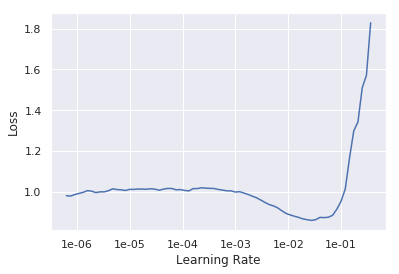

In [12]:
learn.recorder.plot()

In [13]:
optim_lr = round(learn.recorder.lrs[np.argmin(learn.recorder.losses)], 4)
print(f"Best learning rate: {optim_lr}")

Best learning rate: 0.0275


In [14]:
# Converting a list of scalar tensors to a list of floating point numbers.
convert = lambda iter_: list(map(lambda x: x.item(), iter_))

# Accumulating the losses of each epoch to a single number
def accumulate_train_losses(t_l, epochs, no_batches):
    f = []
    for i in range(epochs):
        window = t_l[no_batches * i: no_batches * (i + 1)]
        f.append(sum(window) / len(window))
    
    return f

### Plot train loss and validation loss for each value of learning rate chosen

epoch,train_loss,valid_loss,time
0,1.447129,1.522602,00:27
1,1.444641,1.315038,00:33
2,1.393445,1.558873,00:36
3,1.247572,1.083012,00:56
4,1.332013,1.720416,01:52
5,1.469041,1.438491,00:57
6,1.430518,1.257499,00:54
7,1.241044,1.049011,00:50
8,1.342911,1.102202,00:50
9,1.361612,2.009635,00:52


Epoch 11: reducing lr to 0.020000000000000004
Epoch 17: reducing lr to 0.004000000000000001


epoch,train_loss,valid_loss,time
0,0.218672,0.210096,00:27
1,0.217133,0.213475,00:28
2,0.201692,0.229505,00:27
3,0.206148,0.196917,00:27
4,0.215384,0.216882,00:28
5,0.223619,0.257474,00:26
6,0.205885,0.192503,00:25
7,0.205890,0.200277,00:30
8,0.195971,0.199511,00:27
9,0.199597,0.203285,00:28


Epoch 14: reducing lr to 0.002


epoch,train_loss,valid_loss,time
0,0.166685,0.170025,00:25
1,0.158019,0.164784,00:24
2,0.152112,0.159580,00:27
3,0.140355,0.143752,00:29
4,0.139731,0.139305,00:27
5,0.138021,0.140128,00:27
6,0.128799,0.131263,00:26
7,0.134573,0.126821,00:28
8,0.126960,0.133155,00:26
9,0.126164,0.134738,00:27


epoch,train_loss,valid_loss,time
0,0.347661,0.377244,00:26
1,0.333084,0.351079,00:27
2,0.354954,0.344854,00:26
3,0.346940,0.350271,00:27
4,0.355304,0.342004,00:26
5,0.337339,0.378715,00:26
6,0.342381,0.325175,00:27
7,0.341623,0.380912,00:27
8,0.327342,0.369241,00:27
9,0.344173,0.325579,00:27


Epoch 10: reducing lr to 0.0055000000000000005


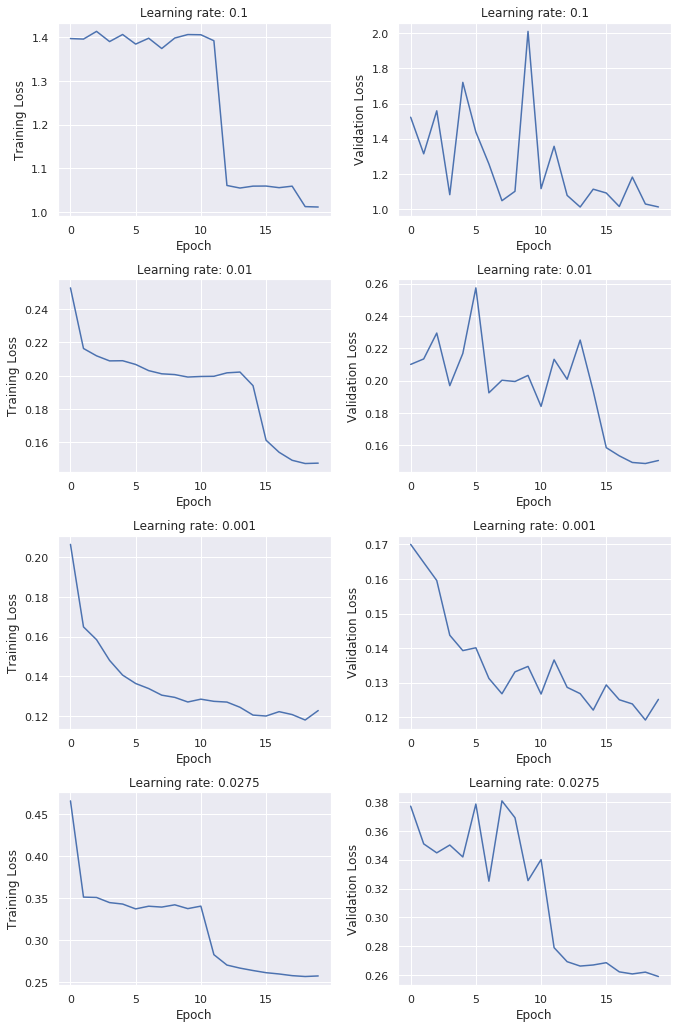

In [16]:
show_lrs = [0.1, 0.01, 0.001, optim_lr]
fig, ax = plt.subplots(len(show_lrs), 2, figsize=(4.8 * 2, 3.6 * len(show_lrs)))

min_loss = float('inf')
min_lr = None

for idx, lr in enumerate(show_lrs):
    model = AE_3D_200()
    learn = basic_train.Learner(
        data=db,
        model=model,
        loss_func=rmse_loss,
        wd=1e-6, callback_fns=callbacks.ActivationStats,
        bn_wd=False,
        true_wd=True
    )
    
    ## ReduceLR Callback applied to check the increase in the validation loss after 3 epochs
    learn.fit(20, lr=lr, wd=1e-6, callbacks=[callbacks.ReduceLROnPlateauCallback(learn=learn, patience=3)])
    # accumulate train losses
    new_train = accumulate_train_losses(convert(learn.recorder.losses), len(learn.recorder.val_losses), NO_BATCHES)
    
    _ = sns.lineplot(range(len(new_train)), new_train, ax=ax[idx, 0])
    _.set_title(f"Learning rate: {lr}")
    _.set_xlabel("Epoch")
    _.set_ylabel("Training Loss")
    _ = sns.lineplot(range(len(learn.recorder.val_losses)), convert(learn.recorder.val_losses), ax=ax[idx, 1])
    _.set_title(f"Learning rate: {lr}")
    _.set_xlabel("Epoch")
    _.set_ylabel("Validation Loss")
    
    if learn.recorder.val_losses[-1] < min_loss:
        learn.save(f"trained_model_{lr}")
        min_loss = learn.recorder.val_losses[-1]
        min_lr = lr

_ = plt.tight_layout()

## Testing the trained model

### Normalizing the input test data

In [17]:
# Here I am assuming that the test data (or unseen data) is coming in one by one rather than in batches.
# Thus, I am normalizing this test data with the mean and standard deviation of the train data.

partial_test_df_normalized = (partial_test_df - train_mean) / train_std

### Comparing the input and output values by comparing histograms

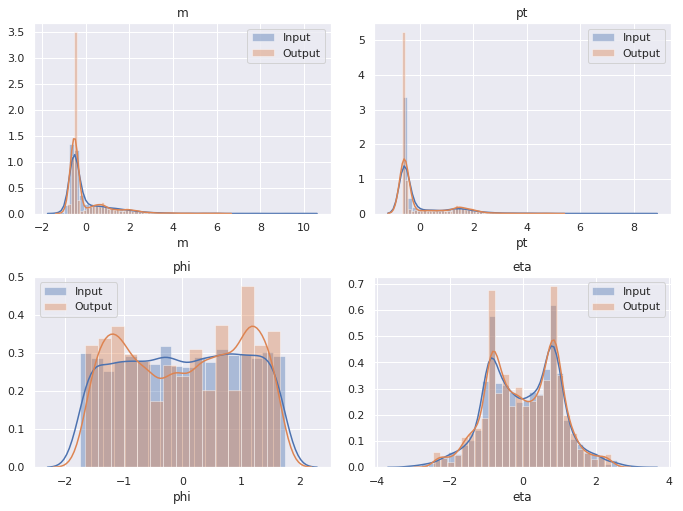

In [18]:
test_outputs = model(torch.FloatTensor(partial_test_df_normalized.values)).detach().numpy()
# test_inputs.detach().numpy().shape
cols = partial_test_df_normalized.columns
fig, ax = plt.subplots(2, 2, figsize=(4.8 * 2, 3.6 * 2))

for idx, axis in enumerate(ax.flatten()):
    _ = sns.distplot(partial_test_df_normalized[cols[idx]], ax=axis, label="Input")
    _ = sns.distplot(test_outputs[:, idx], ax=axis, label="Output")
    _.set_title(f"{cols[idx]}")
    _ = _.legend()

_ = plt.tight_layout()

#### We can see that our auto encoder is able to encode our 4D data with very little loss in the orginal information.